In [1]:
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import random
import matplotlib.pyplot as plt
import numpy as np
from utils import *

random.seed(0)
torch.manual_seed(0)

In [2]:
# Load data
dataset = KarateClub()
data = dataset[0]  # Graph data
num_features = data.x.shape[1]
print(f"Number of features before PCA: {num_features}")

Number of features before PCA: 34


## GNN Model

In [3]:
# Define a simple GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## 1. Karate classification without PCA

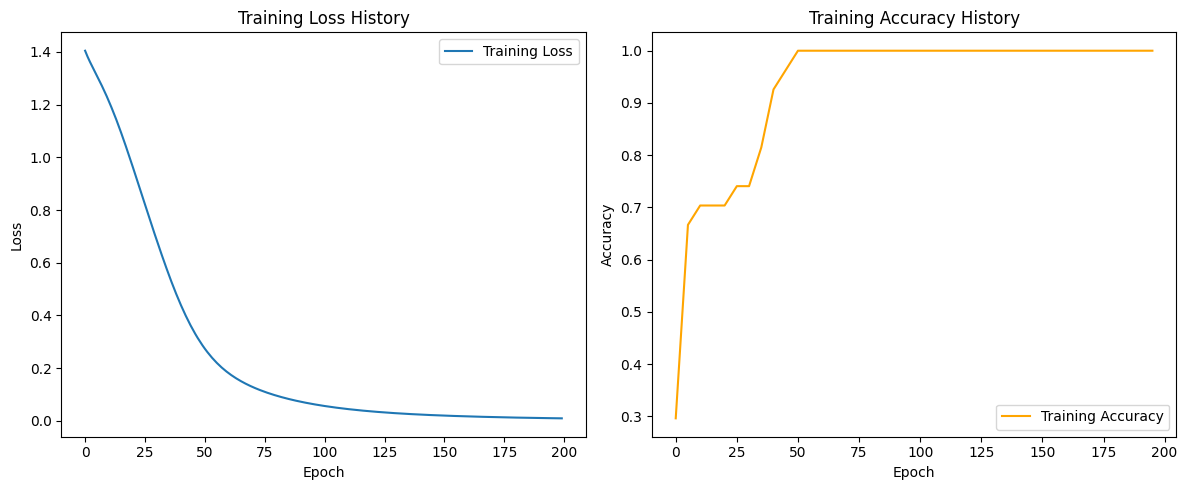

Train Accuracy: 1.0000
Test Accuracy: 1.0000


In [4]:
# Load the Karate Club dataset
dataset = KarateClub()
data = dataset[0]

# Model initialization
input_dim = dataset.num_node_features
hidden_dim = 16
output_dim = dataset.num_classes

model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

generate_train_test(data)

# Training loop
n_epochs = 200
loss_history, train_acc_history = train_loop(n_epochs, model, optimizer, data)

plot_training_history(loss_history, train_acc_history)
   
train_acc, test_acc = test(model, data)
print(f'Train Accuracy: {train_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

## 2. Karate classification with PCA

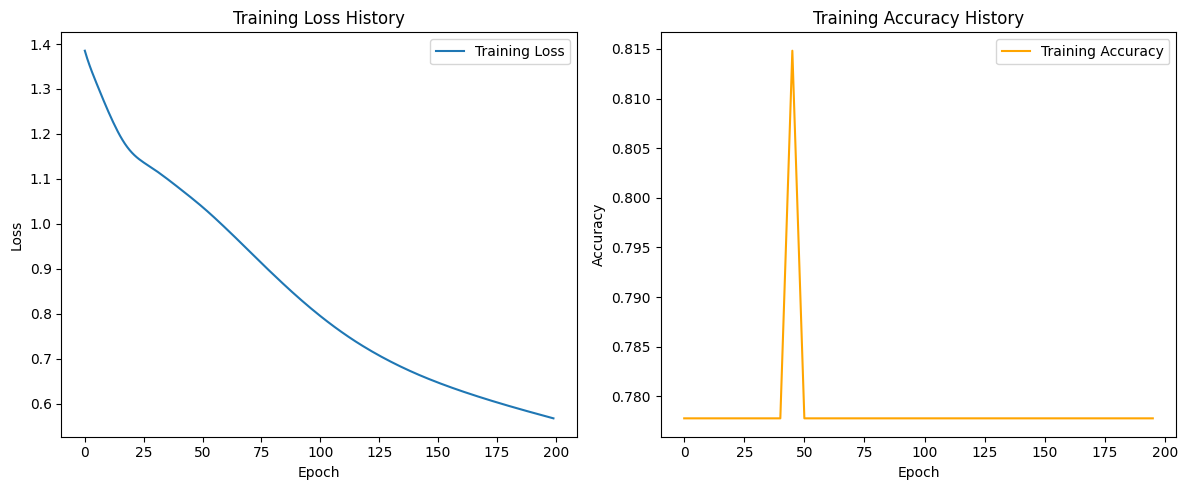

Train Accuracy: 0.7778
Test Accuracy: 0.4286


In [5]:
# Load data
dataset = KarateClub()
data = dataset[0]  # Graph data

generate_train_test(data)

# Fit PCA on training data only
pca = PCA(n_components=2)
train_features = data.x[data.train_mask].numpy()
pca.fit(train_features)

# Transform both training and testing features using the fitted PCA
data.x = torch.tensor(pca.transform(data.x.numpy()), dtype=torch.float)

# Model, optimizer, and data preparation
model = GCN(input_dim=pca.n_components_, hidden_dim=16, output_dim=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 200
loss_history, train_acc_history = train_loop(n_epochs, model, optimizer, data)

plot_training_history(loss_history, train_acc_history)
   
train_acc, test_acc = test(model, data)
print(f'Train Accuracy: {train_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

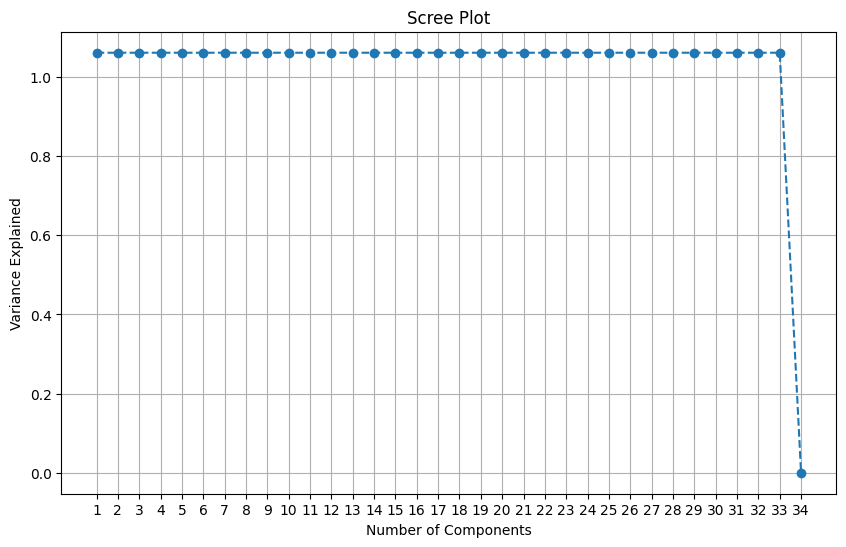

In [6]:
dataset = KarateClub()
data = dataset[0]  # Graph data

# Standardizing the features
X = data.x.numpy()
X_std = StandardScaler().fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_std)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1, step=1))  # Adding 1 because Python indexes at 0
plt.grid(True)
plt.show()

In [7]:
data.x.numpy()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [8]:
(data.x == torch.eye(data.num_nodes)).all()

tensor(True)

# Conclusion

Karate Club Dataset is not usable for dimensionality purpose, as the nodes don't have the features. They are only artificially created one-hot encoded vectors.